<a href="https://www.kaggle.com/code/tornikeonoprishvili/fdtd-silver-cylinder-drude-lorentz-dispersion?scriptVersionId=100366291" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
!conda install -y -c conda-forge pymeep pymeep-extras seaborn

In [ ]:
%matplotlib inline

import meep as mp
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# from meep.materials import Ag, Ag_visible # DO NOT USE THIS


In [ ]:
# scale is nanometer
nm = 1
scale_factor = nm
um = 1000 * nm

In [ ]:
# Meep requires to manually change scale of materials.py
# in order to work with non-um scales.
!cp {mp.materials.__file__} scaled_materials.py
sed_command = f'9i um_scale = {scale_factor / um} * um_scale'
!sed -i '{sed_command}' scaled_materials.py
!head -n 12 scaled_materials.py

Careful with the resolution!

See this diagram here (figure b), the resolution can be at most 8um/pixel

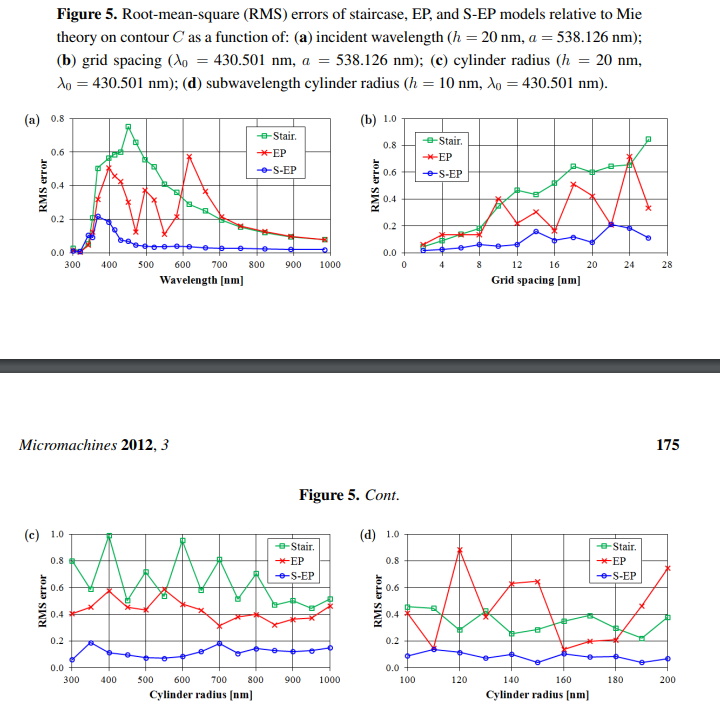

Otherwise the simulation will diverge.

In [ ]:
wavelength = 430.501 # lambda_0, wavelength of source
# Currently 
# Note that usually, h can be at most 1/20 of wavelength
# Now, with plasmonic curved surfaces, it has to be even smaller 
# Otherwise the simulation will diverge
# h = 20 # DIVERGES!
h = 8  # grid spacing - doesn't diverge
# a = 1.25 * wavelength
a = 538.126 # cylinder radius
dpml = 1.0 * wavelength # pml width
s = wavelength * 5 + dpml * 2 # full grid size
resolution = 1 / h # pixels per unit of distance

In [ ]:
print('pixels per wavelength',wavelength / h)
print('Usually has to be >20, but in this case has to be higher (see figure 1, b above)')
print('total size in pixels', resolution * s)

In [ ]:
from scaled_materials import Ag, Au

cell_size = mp.Vector3(s,s)
boundary_layers = [mp.PML(thickness=dpml,
                          direction=mp.ALL)]

# epsilon_complex = -6.06 + 0.197j
# omega = 1/wavelength
# omega_plasma = omega * ( (( 1 - epsilon_complex.real) ** 2 + epsilon_complex.imag ** 2)
#                          / (1 - epsilon_complex.real)) ** .5
# coll_freq = omega * (epsilon_complex.imag / (1 - epsilon_complex.real))
# E_susceptibilities = [mp.DrudeSusceptibility(
#     frequency=omega_plasma,sigma=1,gamma=coll_freq)]
# material = mp.Medium(epsilon=1, 
#                      E_susceptibilities=E_susceptibilities)


material = Ag
geometry = [mp.Cylinder(radius=a,
                        center=mp.Vector3(0,0,0), 
                        material=Ag)]

# beam_x0 = mp.Vector3(0,3.0)    # beam focus (relative to source center)
# rot_angle = 0  # CCW rotation angle about z axis (0: +y axis)
# beam_kdir = mp.Vector3(0,wavelength,0)\
#     .rotate(mp.Vector3(0,0,1),math.radians(rot_angle))  # beam propagation direction

sources = [
#     mp.GaussianBeamSource(
#         src=mp.ContinuousSource(wavelength=wavelength, 
#                                 width=2 * wavelength),
#         center=mp.Vector3(0, -s/2 + dpml + 1.0, 0),
#         size=mp.Vector3(s - dpml*2,0,0),
#         component=mp.Ez,
#         beam_x0=mp.Vector3(0, s/4),
#         beam_kdir=mp.Vector3(0,1,0),
#         beam_w0=s/2,
#         beam_E0=mp.Vector3(0,0,1)
#         eig_kpoint=beam_kdir,
#     )
    mp.Source(
        src=mp.ContinuousSource(wavelength=wavelength, 
                                width=2 * wavelength),
        center=mp.Vector3(0, -s/2 + dpml + 1.0, 0),
        size=mp.Vector3(s - dpml*2,0,0),
        component=mp.Ez,
    )
]


sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
#                     k_point=beam_kdir,
                    sources=sources,
                   )

f = plt.figure(figsize = (8,8))
animation = mp.Animate2D(sim, mp.Ez, f=f, eps_parameters=dict(contour=True))

plt.close()
t_steps = 100000
fps = 4
anim_seconds = 10
anim_frames = anim_seconds * fps
sim.run(
    mp.at_every(t_steps / anim_frames, animation),
    until=t_steps
)

animation.to_mp4(fps, 'animation.mp4')

sim.plot2D(fields=mp.Ez)

plt.savefig('Ez_angle{}.png'.format(rot_angle),bbox_inches='tight',pad_inches=0)

In [ ]:
from IPython.display import Video
Video('animation.mp4')